In [30]:
import yfinance as yf
import pandas as pd
import pandas_ta as ta
import numpy as np
import matplotlib.pyplot as plt

In [31]:
'''
Tickers to try this program out with:
dkng u path nvda arkg pltr ttd sofi ionq tsla googl celh arm rblx hcp ai joby
'''

'\nTickers to try this program out with:\ndkng u path nvda arkg pltr ttd sofi ionq tsla googl celh arm rblx hcp ai joby\n'

In [32]:
ticker = 'u'

In [33]:
# Fetch data for a ticker

df_intra = yf.download(ticker, start='2024-01-02', end='2024-09-27', interval='60m')
df = yf.download(ticker, start='2024-01-02', end='2024-09-27')

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [34]:
# EMA Calculate function

def calculate_ema(fast_ema, slow_ema, df):
    fema = df['Close'].ewm(span=fast_ema, adjust=False).mean()
    sema = df['Close'].ewm(span=slow_ema, adjust=False).mean()
    return fema, sema

df['EMA_A'], df['EMA_B'] = calculate_ema(5, 7, df)


In [35]:
# RSI Calulate function

def calculate_rsi(df, overbought_level, oversold_level):
    delta = df['Close'].diff(1)

    # Calculate the exponentially weighted moving averages of gains and losses
    gain_ewm = delta.where(delta > 0, 0).ewm(span=14, adjust=False).mean()
    loss_ewm = -delta.where(delta < 0, 0).ewm(span=14, adjust=False).mean()

    # Calculate the relative strength (RS)
    rs = gain_ewm / loss_ewm

    # Calculate the RSI
    rsi = 100 - (100 / (1 + rs))

    # Compute the median between overbought and oversold levels
    median_rsi = np.median([overbought_level, oversold_level])

    return rs, rsi, median_rsi

rs, rsi, median_rsi = calculate_rsi(df, 90, 10)

# Add the Median_RSI column indicating whether RSI is above or below the median
df['Median_RSI'] = np.where(rsi > median_rsi, 'above_median', 'below_median')

# add rsi column with rsi value
df['rsi'] = rsi

# # ensure rsi is above median to be used in the crossed_above condition
rsi_check = df['rsi'] >= median_rsi

In [36]:
# Calculate MACD and signal line
def calculate_macd(df):
    exp1 = df['Close'].ewm(span=12, adjust=False).mean()
    exp2 = df['Close'].ewm(span=26, adjust=False).mean()
    macd = exp1 - exp2
    signal = macd.ewm(span=9, adjust=False).mean()
    return macd, signal

df['MACD'], df['Signal'] = calculate_macd(df)

In [37]:
def signal(df):
    crossed_above_with_rsi = (df['EMA_A'] > df['EMA_B']) & (df['EMA_A'].shift(1) < df['EMA_B'].shift(1)) & (rsi_check)
    crossed_above = (df['EMA_A'] > df['EMA_B']) & (df['EMA_A'].shift(1) < df['EMA_B'].shift(1)) 
    crossed_above_macd = (df['MACD'] > df['Signal']) & (df['MACD'].shift(1) <= df['Signal'].shift(1))
    return crossed_above_with_rsi, crossed_above, crossed_above_macd

# Capture the output of the signal function
crossed_above_with_rsi, crossed_above, crossed_above_macd = signal(df)

In [38]:
# This uses the result of the signal function.  
df.loc[crossed_above_with_rsi, 'Cross_Direction'] = 'crossed up'

# Identify when the A-day EMA crosses below the B-Day EMA
crossed_below = (df['EMA_A'] < df['EMA_B']) & (df['EMA_A'].shift(1) > df['EMA_B'].shift(1))

df.loc[crossed_below, 'Cross_Direction'] = 'crossed down'

In [39]:
# Filter for rows where the 5-day EMA crossed either above or below the 21-day EMA
condition_met = df[df['Cross_Direction'].notna()]

# Display the dates when the conditions were met and the direction of the crossover
print("\nDates when the conditions were met and cross direction:")
condition_met[['Close', 'EMA_A', 'EMA_B', 'Cross_Direction', 'Median_RSI', 'rsi']]


Dates when the conditions were met and cross direction:


,Close,EMA_A,EMA_B,Cross_Direction,Median_RSI,rsi
Date,,,,,,
2024-02-09,33.820000,33.075148,32.988854,crossed up,above_median,56.162168
2024-02-20,32.020000,33.423361,33.481234,crossed down,below_median,37.944930
2024-03-21,27.570000,26.849365,26.797912,crossed up,above_median,54.659197
2024-03-28,26.700001,26.852592,26.853284,crossed down,below_median,42.923224
2024-04-09,27.080000,26.307614,26.284545,crossed up,above_median,59.789695
2024-04-10,25.920000,26.178409,26.193409,crossed down,below_median,43.456872
2024-04-29,24.990000,24.083924,24.005539,crossed up,above_median,61.046764
2024-05-09,24.160000,24.498656,24.503587,crossed down,below_median,45.022537
2024-07-11,16.520000,15.958333,15.955169,crossed up,above_median,56.082941


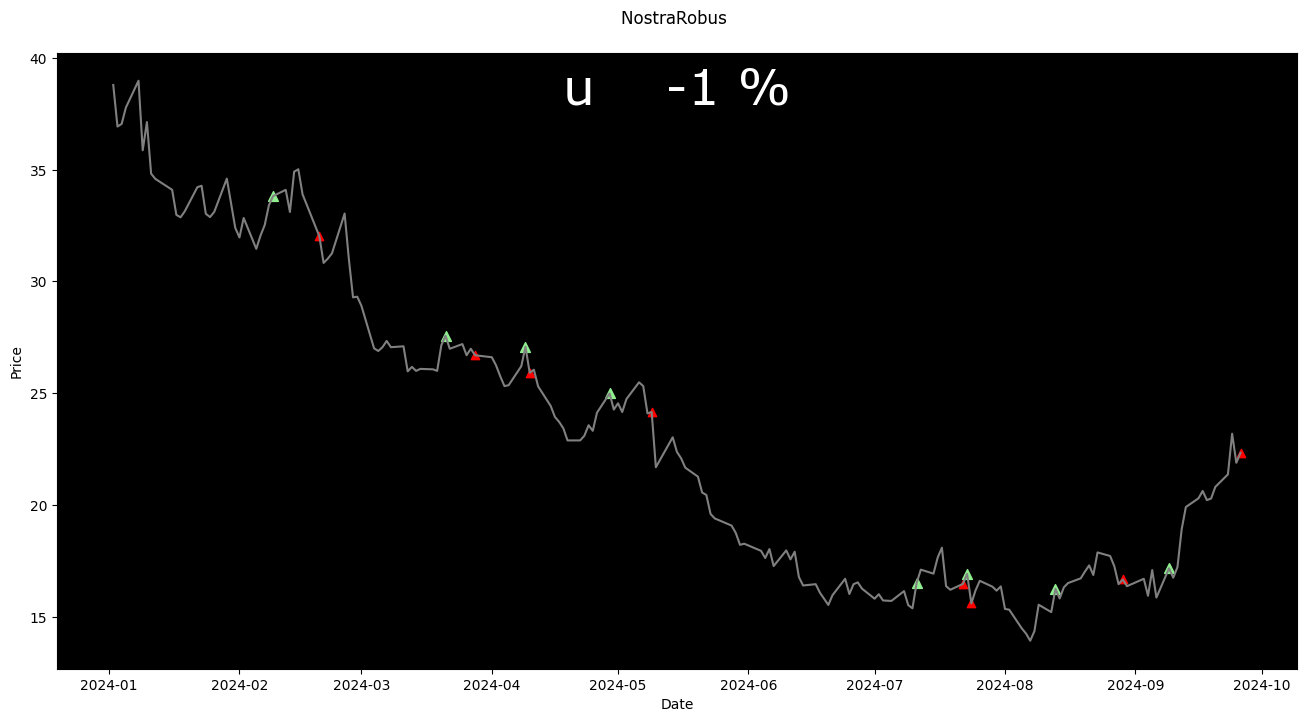

Results For Ticker:   u
Initial Investment:  33.81999969482422
Final Portfolio Value:  33
Profit/Loss:  -0.4
Percent: -1.3%




,Action,Date,Open,Close,Price,Cash
0,Buy,2024-02-09,33.860001,33.820000,33.820000,0.000000
1,Sell,2024-02-20,33.270000,32.020000,33.270000,32.020000
2,Buy,2024-03-21,27.610001,27.570000,27.570000,4.450001
3,Sell,2024-03-28,27.150000,26.700001,27.150000,31.150002
4,Buy,2024-04-09,26.559999,27.080000,27.080000,4.070002
5,Sell,2024-04-10,26.320000,25.920000,26.320000,29.990002
6,Buy,2024-04-29,24.420000,24.990000,24.990000,5.000002
7,Sell,2024-05-09,23.750000,24.160000,23.750000,29.160002
8,Buy,2024-07-11,15.810000,16.520000,16.520000,12.640001
9,Sell,2024-07-22,16.370001,16.469999,16.370001,29.110001


In [40]:
# Initialize variables
init_cost = 1 # we need this set so when conditions are not met, we don't divide by 0
cash = init_cost  # Initial cash balance
shares_owned = 0
portfolio_value = cash
prev_crossed_above = False
rsi_above_median = False
transactions = []
last_trans = 'crossed down'
df.iloc[-1, df.columns.get_loc('Cross_Direction')] = last_trans

# Plot the line graph with arrows indicating the direction of crossover
plt.figure(figsize=(16, 8))
plt.plot(df.index, df['Close'], label='Close Price', color='gray')
plt.gca().set_facecolor('black')  # Set the background color to black


# Find the first crossed up event and set the initial cost
for index, row in df.iterrows():
    if row['Cross_Direction'] == 'crossed up':
        init_cost = row['Close']  # Set init_cost to the price at the first crossed up event
        cash = init_cost  # Set cash to the initial cost
        break

# Loop through the dataframe
for index, row in df.iterrows():
    if row['Cross_Direction'] == 'crossed up' and prev_crossed_above == False:  # Check if the Cross_Direction column is 'crossed up'
        # Buy one share
        # shares_owned += 1
        cash -= row['Close']  # Deduct purchase price from cash
        transactions.append(('Buy', index, row['Open'], row['Close'], row['Close'], cash))
        prev_crossed_above = True
        plt.scatter(index, row['Close'], marker='^', color='lightgreen', s=50, label='Crossed Up')
    elif row['Cross_Direction'] == 'crossed down' and prev_crossed_above:  # Check if the Cross_Direction column is 'crossed down':
        cash += row['Close'] #* shares_owned  # Add sale price to cash
        transactions.append(('Sell', index, row['Open'], row['Close'], row['Open'], cash))
        prev_crossed_above = False
        plt.scatter(index, row['Close'], marker='^', color='red', label='Crossed Down')
    else:
        pass
    
# Calculate final portfolio value
portfolio_value = cash

# Evaluate performance
initial_investment = init_cost # Initial cash investment
profit_loss = portfolio_value - initial_investment

percent = (profit_loss / initial_investment) * 100

# Add the ticker symbol and other things as labels
plt.text(0.5, 0.9, ticker + '    ' + str(round(percent)) + ' %', transform=plt.gca().transAxes, fontsize=36, verticalalignment='bottom', \
         horizontalalignment='center', fontname='MS Reference Sans Serif', fontweight='bold', color='white')
plt.title('NostraRobus \n', fontname='MS Reference Sans Serif', fontweight='bold', color='black')
plt.xlabel('Date', color='black')
plt.ylabel('Price', color='black')
plt.tick_params(axis='x', colors='black')
plt.tick_params(axis='y', colors='black')
plt.grid(False)
plt.show()



print('Results For Ticker:  ', ticker)
print('Initial Investment: ', initial_investment)
print("Final Portfolio Value: ", int(portfolio_value))
print("Profit/Loss: ", round(profit_loss,1))
print("Percent: {:.1f}%".format(percent))
print('\n')
transactions_df = pd.DataFrame(transactions, columns=['Action', 'Date', 'Open', 'Close', 'Price', 'Cash'])
transactions_df



In [41]:
# df.to_csv(r'C:\Users\rindel\Downloads\filename.csv', index=True)
# transactions_df.to_csv('filename.csv', index=True)


In [42]:
# # Inspect data for accuracy. Filter the DataFrame to include rows starting from a specific date
# specific_date = '2024-08-30'
# filtered_df = df.loc[specific_date:]
# specific_col = ['Open', 'Close', 'Cross_Direction', 'Median_RSI', 'EMA_A', 'EMA_B', 'rsi']
# filtered_df[specific_col].head(2)

todo
need to add a different method for last transaction so it is included in profit calc but not printed as a last trans which would prevent me from seeing the next sell.  commented out for now

add intra day 1 hour into the calc